Predict the sales of houses in King County with an accuracy of at least 75-80% and       understand which factors are responsible for higher property value - $650K and above.

In [ ]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost
import math
from scipy.stats import pearsonr
from sklearn.model_selection import cross_validate
#from sklearn import cross_validation, tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.linear_model import LinearRegression
#regr = linear_model.LinearRegression()
regr = LinearRegression()
import warnings
warnings.filterwarnings("ignore")

In [38]:
data = pd.read_csv(r"C:\Code\house_data.csv")
data.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
#print(data.dtypes)
#data.shape
#data.dtypes
print(data.columns)
print(len(data))
print(len(data.columns))
print(data.dtypes.unique()) #3 types data h, int, objective and float

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')
21597
21
[dtype('int64') dtype('O') dtype('float64')]


In [7]:
data.select_dtypes(include=['O']).columns.tolist() # catogorical data check krne k liye inside any objective, we can ignore it

['date']

In [8]:
print(data.isnull().any().sum(), ' / ', len(data.columns))
print(data.isnull().any(axis=1).sum(), ' / ', len(data))

0  /  21
0  /  21597


In [9]:
features = data.iloc[:,3:].columns.tolist() # pehla 3 chodke baki sbko features mein include kr liya
target = data.iloc[:,2].name # price is the target to get the prediction

In [10]:
correlation={} # we will check other values with price , that how much co related with price, most corelatated values ko select krna h
for f in features:
    data1 = data[[f,target]]
    x1= data1[f].values
    x2= data1[target].values
    key = f +  ' vs ' + target
    correlation[key] = pearsonr(x1,x2)[0]
#correlation

A Pearson correlation is a number between -1 and 1 that indicates the extent to which two variables are linearly related. The Pearson correlation is also known as the “product moment correlation coefficient” (PMCC) or simply “correlation”. upar jo use kiya usko explain krne ka kosis!

In [11]:
data_correlations = pd.DataFrame(correlation, index=['Value']).T # checking which one is mostly co realted with price
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index] 

,Value
sqft_living vs price,0.701917
grade vs price,0.667951
sqft_above vs price,0.605368
sqft_living15 vs price,0.585241
bathrooms vs price,0.525906
view vs price,0.397370
sqft_basement vs price,0.323799
bedrooms vs price,0.308787
lat vs price,0.306692
waterfront vs price,0.266398


<function matplotlib.pyplot.show(*args, **kw)>

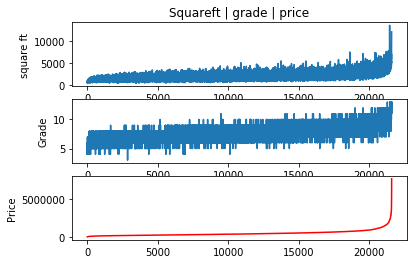

In [12]:
y = data.loc[:,['sqft_living','grade', target]].sort_values(target,ascending=True).values
x = np.arange(y.shape[0])
plt.subplot(3,1,1)
plt.plot(x,y[:,0])
plt.ylabel("square ft")
plt.title ("Squareft | grade | price")

plt.subplot(3,1,2)
plt.plot(x,y[:,1])
plt.ylabel('Grade')

plt.subplot(3,1,3)
plt.plot(x,y[:,2],'r')
plt.ylabel("Price")

plt.show

In [24]:
new_data = data[['sqft_living','grade', 'sqft_above', 'sqft_living15','bathrooms','view','sqft_basement','lat','waterfront','yr_built','bedrooms']]

In [25]:
X = new_data.values
y = data.price.values

In [30]:
#X_train, X_test, y_train, y_test = cross_validate.train_test_split(X, y ,test_size=0.3)
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2)

In [31]:
regr.fit(X_train, y_train)
print(regr.predict(X_test))

[ 804264.97155518 1267441.98493464  281617.78342646 ...  494183.26259964
  899135.28488716  504698.05451134]


In [32]:
regr.score(X_test,y_test)

0.6963509421599134

In [33]:
print("RMSE: %.2f"
      % math.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))

RMSE: 194078.45


In [34]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

In [35]:
traindf, testdf = train_test_split(X_train, test_size = 0.3)
xgb.fit(X_train,y_train)

[20:08:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.08, max_delta_step=0,
             max_depth=7, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.75, verbosity=1)

In [37]:
predictions = xgb.predict(X_test)
print(explained_variance_score(predictions,y_test))

0.8164092079528724
